In [1]:
# %load ~/ipyhead
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

In [2]:
!pip install pyensembl

In [3]:
!pyensembl install --release 79 --species human

-- Running 'install' for EnsemblRelease(release=79, species='homo_sapiens')
INFO:root:Loaded sequence dictionary from /home/jacquelineburos/.cache/pyensembl/GRCh38/ensembl79/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:root:Loaded sequence dictionary from /home/jacquelineburos/.cache/pyensembl/GRCh38/ensembl79/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle


In [4]:
from pyensembl import cached_release

download datasets and process:

In [5]:
!gsutil ls gs://mz-hammerlab/output/

gs://mz-hammerlab/output/
gs://mz-hammerlab/output/ERR431566.logs.tar.gz
gs://mz-hammerlab/output/ERR431566.tar.gz
gs://mz-hammerlab/output/ERR431567.logs.tar.gz
gs://mz-hammerlab/output/ERR431567.tar.gz
gs://mz-hammerlab/output/ERR431568.logs.tar.gz
gs://mz-hammerlab/output/ERR431568.tar.gz
gs://mz-hammerlab/output/ERR431569.logs.tar.gz
gs://mz-hammerlab/output/ERR431569.tar.gz
gs://mz-hammerlab/output/ERR431570.logs.tar.gz
gs://mz-hammerlab/output/ERR431570.tar.gz
gs://mz-hammerlab/output/ERR431571.logs.tar.gz
gs://mz-hammerlab/output/ERR431571.tar.gz
gs://mz-hammerlab/output/ERR431572.logs.tar.gz
gs://mz-hammerlab/output/ERR431572.tar.gz
gs://mz-hammerlab/output/ERR431573.logs.tar.gz
gs://mz-hammerlab/output/ERR431573.tar.gz
gs://mz-hammerlab/output/ERR431574.logs.tar.gz
gs://mz-hammerlab/output/ERR431574.tar.gz
gs://mz-hammerlab/output/ERR431575.logs.tar.gz
gs://mz-hammerlab/output/ERR431575.tar.gz
gs://mz-hammerlab/output/ERR431576.logs.tar.gz
gs://mz-hammerlab/output/ERR431576.ta

In [6]:
!mkdir -p ./data
!gsutil cp gs://mz-hammerlab/output/ERR431624.tar.gz ./data;
!gsutil cp gs://mz-hammerlab/output/ERR431624.logs.tar.gz ./data;
!cd data && tar -zxvf ERR431624.tar.gz && rm ERR431624.tar.gz;
!cd data && tar -zxvf ERR431624.logs.tar.gz && rm ERR431624.logs.tar.gz;

Copying gs://mz-hammerlab/output/ERR431624.tar.gz...
Copying gs://mz-hammerlab/output/ERR431624.logs.tar.gz...
output/ERR431624/
output/ERR431624/abundance.tsv
output/ERR431624/abundance.h5
output/ERR431624/run_info.json
logs/ERR431624/out.txt
logs/ERR431624/sar.txt
logs/ERR431624/time.txt


In [7]:
def download(s):
    !gsutil cp gs://mz-hammerlab/output/"$s".tar.gz ./data;
    !gsutil cp gs://mz-hammerlab/output/"$s".logs.tar.gz ./data;
    !cd data && tar -zxvf "$s".tar.gz && rm "$s".tar.gz;
    !cd data && tar -zxvf "$s".logs.tar.gz && rm "$s".logs.tar.gz;
    print 'downloaded', s, 'files to ./data'
download('ERR431583')

Copying gs://mz-hammerlab/output/ERR431583.tar.gz...
Copying gs://mz-hammerlab/output/ERR431583.logs.tar.gz...
output/ERR431583/
output/ERR431583/abundance.tsv
output/ERR431583/abundance.h5
output/ERR431583/run_info.json
logs/ERR431583/out.txt
logs/ERR431583/sar.txt
logs/ERR431583/time.txt
downloaded ERR431583 files to ./data


In [8]:
!ls -l data/output

total 40
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 29 21:31 ERR431572
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 29 23:40 ERR431583
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 30 00:09 ERR431586
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 30 00:51 ERR431589
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 30 02:04 ERR431601
drwxrwxr-x 2 jacquelineburos jacquelineburos 4096 Jul 27 20:57 ERR431606
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 30 02:57 ERR431609
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 30 03:22 ERR431611
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 30 00:36 ERR431619
drwxr-xr-x 2 jacquelineburos jacquelineburos 4096 Jul 31 19:53 ERR431624


In [9]:
from pyensembl import cached_release
import os
ensembl_release = cached_release(79)
def load_multiple(files):
    """
    files is ordered list of samples. they will be assigned sample ids 1-n.
    """
    dfs = []
    for ix, f in enumerate(files):
        filename = 'data/output/%s/abundance.tsv' % f
        if not os.path.exists(filename):
            download(f)
        df = pd.read_csv(filename, sep='\t')
        df['sample_id'] = ix+1
        df['filename'] = f
        df['gene_name'] = df['target_id'].map(lambda t: ensembl_release.gene_name_of_transcript_id(t))
        df['log1p_tpm'] = np.log1p(df['tpm'])
        dfs.append(df)
    return pd.concat(dfs)

def prep_simple_summary(df):
    """
    sum counts, abundance (tpm) across genes
    """
    return df.groupby(['sample_id', 'filename', 'gene_name'])[['est_counts', 'tpm']].sum().reset_index()

In [10]:
# process both B cells
simple_summary = prep_simple_summary(load_multiple(['ERR431572', 'ERR431624', 'ERR431583']))
simple_summary.head()

,sample_id,filename,gene_name,est_counts,tpm
0,1,ERR431572,A1BG,80.232280,11.155641
1,1,ERR431572,A1CF,18.042401,0.382263
2,1,ERR431572,A2M,3.000000,1.226161
3,1,ERR431572,A2ML1,21.912401,2.756862
4,1,ERR431572,A2MP1,2.000000,0.092441


In [11]:
simple_summary.tail()

,sample_id,filename,gene_name,est_counts,tpm
104491,3,ERR431583,bP-2189O9.1,0.000000,0.000000
104492,3,ERR431583,bP-2189O9.2,3.263100,0.347490
104493,3,ERR431583,bP-2189O9.4,0.000000,0.000000
104494,3,ERR431583,pk,63.556597,2.080726
104495,3,ERR431583,yR211F11.2,2.000000,0.715197


In [12]:
simple_summary.to_csv('data/summary.simple.tsv', sep='\t', index=None)        

## A quick look at all the datafiles we have

In [13]:
datafiles = pd.read_csv('data_filenames.tsv', sep='\t')
datafiles.head()

,Source,Name,SubSet,Antibody,InnerSize,R1 URI,R1 MD5SUM,R2 URI,R2 MD5SUM,filename
0,SQ_0170,ERS403422,B_CD5,"CD19+,CD5+",467,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,7888a99378b0b5edff03c90a35a10a6c,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,b23a21d1dea86b3ffbffd0d9100a0872,ERR431599
1,SQ_0171,ERS403419,B_CD5,"CD19+,CD5+",459,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,09eef4d1b13d55f319c1ec3c9013557a,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,88ddfeaecc5e7b956e7216d84814bad7,ERR431596
2,SQ_0172,ERS403409,B_CD5,"CD19+,CD5+",448,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,073d797b293b668e1da1d69699a10a3c,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,3b7c926faca663fe4828cad85101cf74,ERR431591
3,SQ_0173,ERS403393,B_CD5,"CD19+,CD5+",356,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,7e2b526384c9e699995965f5c33ada29,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,dc509070645f512f442deb2994fc69d9,ERR431568
4,SQ_0098,ERS403430,B_Memory,"CD19+,CD5-,CD27+",466,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,e14af4009f6c483665016e7ffefa8696,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,b25945403c99a1efced1d359aa39aa0d,ERR431617


In [14]:
datafiles[['filename', 'SubSet', 'Antibody']]

,filename,SubSet,Antibody
0,ERR431599,B_CD5,"CD19+,CD5+"
1,ERR431596,B_CD5,"CD19+,CD5+"
2,ERR431591,B_CD5,"CD19+,CD5+"
3,ERR431568,B_CD5,"CD19+,CD5+"
4,ERR431617,B_Memory,"CD19+,CD5-,CD27+"
5,ERR431569,B_Memory,"CD19+,CD5-,CD27+"
6,ERR431594,B_Memory,"CD19+,CD5-,CD27+"
7,ERR431613,B_Memory,"CD19+,CD5-,CD27+"
8,ERR431608,B_Memory,"CD19+,CD5-,CD27+"
9,ERR431572,B_Naive,"CD19+,CD5-,CD27-"


In [15]:
datafiles[datafiles.SubSet.str.lower().str.contains('treg')]

,Source,Name,SubSet,Antibody,InnerSize,R1 URI,R1 MD5SUM,R2 URI,R2 MD5SUM,filename
44,SQ_0021,ERS403436,CD4_Treg,"CD4+,CD127-,CD25+",450,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,1f30880aa773dcc912b2e7c6db2ae6fe,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,c5d9d48830eb5d183b6ce080b6a329b2,ERR431583
45,SQ_0022,ERS403386,CD4_Treg,"CD4+,CD127-,CD25+",450,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,b9fd31742d7a4eff1790982a64795146,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,ebc1489184defb91e5b8814123413152,ERR431606
46,SQ_0023,ERS403435,CD4_Treg,"CD4+,CD127-,CD25+",450,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,c3435337bcee5dad1524d6af609f47f3,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,66bf895e7b84440297bea97b2aaa07e1,ERR431609
47,SQ_0065,ERS403410,CD4_Treg,"CD4+,CD127-,CD25+",449,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,8aae8956187b8fdfd0ba12701feb173b,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,6b42df8aa6924553d2f40de84eead826,ERR431601
48,SQ_0067,ERS403428,CD4_Treg,"CD4+,CD127-,CD25+",444,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,d36596f9f35d041225666659e6494cf7,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR431/ERR4...,8fa326a4a158bcec4c5e9adc2f12316c,ERR431589


In [16]:
metadata = datafiles[['filename', 'SubSet', 'Antibody']]
metadata.head()

,filename,SubSet,Antibody
0,ERR431599,B_CD5,"CD19+,CD5+"
1,ERR431596,B_CD5,"CD19+,CD5+"
2,ERR431591,B_CD5,"CD19+,CD5+"
3,ERR431568,B_CD5,"CD19+,CD5+"
4,ERR431617,B_Memory,"CD19+,CD5-,CD27+"


In [17]:
## inspired by 
## http://stackoverflow.com/questions/17116814/pandas-how-do-i-split-text-in-a-column-into-multiple-rows
def split_rows_by(df, field, suffix='', by=','):
    s = df[field].str.split(by).apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1)
    s.name = '{}{}'.format(field, suffix)
    if suffix == '':
        del df[field]
    return df.join(s)


In [18]:
## reshape metadata to list antibody classes as features
## version 1
df = metadata.copy()
subsets = split_rows_by(df, 'Antibody')
del subsets['SubSet']
subsets['value'] = 1
subsets.drop_duplicates(['filename','Antibody', 'value'], inplace=True)
subsets = subsets.pivot('filename', 'Antibody', 'value')

#subsets.reset_index(inplace=True)
#subsets.index = subsets.index.droplevel(-1)
subsets.head()


Antibody,CCR6+,CCR7+,CCR7-,CD127-,CD161+,CD19+,CD25+,CD27+,CD27-,CD4+,CD45RA+,CD45RA-,CD45RO+,CD45RO-,CD5+,CD5-,CD8+,CRTH2+,CXCR3+,CXCR3-
filename,,,,,,,,,,,,,,,,,,,,
ERR431566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
ERR431567,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
ERR431568,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
ERR431569,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
ERR431570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [19]:
## reshape metadata to list antibody classes as features
df = metadata.copy()
subsets = split_rows_by(df, 'Antibody')
subsets['antibody'] = subsets.Antibody.replace(to_replace=ur'.$', value='', inplace=False, regex=True)
subsets['value'] = subsets.Antibody.replace(to_replace=ur'^.+(.)$', value=ur'\1', inplace=False, regex=True)
del subsets['Antibody']
del subsets['SubSet']
subsets.drop_duplicates(['filename','antibody', 'value'], inplace=True)
subsets = subsets.pivot('filename', 'antibody', 'value')
subsets.reset_index(inplace=True)
subsets = pd.merge(subsets, df.loc[:,['filename','SubSet']], on='filename', how='outer')
subsets.head()

antibody,filename,CCR6,CCR7,CD127,CD161,CD19,CD25,CD27,CD4,CD45RA,CD45RO,CD5,CD8,CRTH2,CXCR3,SubSet
0,ERR431566,None,None,None,None,None,None,None,+,None,None,None,None,+,-,CD4_Th2
1,ERR431567,None,-,None,None,None,None,None,None,-,+,None,+,None,None,CD8_Effector
2,ERR431568,None,None,None,None,+,None,None,None,None,None,+,None,None,None,B_CD5
3,ERR431569,None,None,None,None,+,None,+,None,None,None,-,None,None,None,B_Memory
4,ERR431570,None,None,None,None,None,None,None,+,None,None,None,None,None,+,CD4_Th1


In [20]:
def prep_filename_metadata(datafiles):
    df = datafiles[['filename', 'SubSet', 'Antibody']].copy()
    subsets = split_rows_by(df, 'Antibody')
    subsets['antibody'] = subsets.Antibody.replace(to_replace=ur'.$', value='', inplace=False, regex=True)
    subsets['value'] = subsets.Antibody.replace(to_replace=ur'^.+(.)$', value=ur'\1', inplace=False, regex=True)
    del subsets['Antibody']
    del subsets['SubSet']
    subsets.drop_duplicates(['filename','antibody', 'value'], inplace=True)
    subsets = subsets.pivot('filename', 'antibody', 'value')
    subsets.reset_index(inplace=True)
    subsets = pd.merge(subsets, df.loc[:,['filename','SubSet']], on='filename', how='outer')
    return subsets


In [21]:
simple_summary.head()

,sample_id,filename,gene_name,est_counts,tpm
0,1,ERR431572,A1BG,80.232280,11.155641
1,1,ERR431572,A1CF,18.042401,0.382263
2,1,ERR431572,A2M,3.000000,1.226161
3,1,ERR431572,A2ML1,21.912401,2.756862
4,1,ERR431572,A2MP1,2.000000,0.092441


In [22]:

def prep_annotated_summary(df, metadata, **kwargs):
    """
    sum counts, abundance (tpm) across genes
    """
    return pd.merge(df, metadata, on='filename', how='left', **kwargs)


In [23]:
annotated_summary = prep_annotated_summary(simple_summary, metadata=subsets)

In [24]:
annotated_summary.head()

,sample_id,filename,gene_name,est_counts,tpm,CCR6,CCR7,CD127,CD161,CD19,CD25,CD27,CD4,CD45RA,CD45RO,CD5,CD8,CRTH2,CXCR3,SubSet
0,1,ERR431572,A1BG,80.232280,11.155641,None,None,None,None,+,None,-,None,None,None,-,None,None,None,B_Naive
1,1,ERR431572,A1CF,18.042401,0.382263,None,None,None,None,+,None,-,None,None,None,-,None,None,None,B_Naive
2,1,ERR431572,A2M,3.000000,1.226161,None,None,None,None,+,None,-,None,None,None,-,None,None,None,B_Naive
3,1,ERR431572,A2ML1,21.912401,2.756862,None,None,None,None,+,None,-,None,None,None,-,None,None,None,B_Naive
4,1,ERR431572,A2MP1,2.000000,0.092441,None,None,None,None,+,None,-,None,None,None,-,None,None,None,B_Naive


## look at CD19+ B cell group

In [25]:
annotated_summary.loc[annotated_summary['CD19']=='+','SubSet'].unique()

array(['B_Naive'], dtype=object)

In [26]:
#sns.boxplot(data=annotated_summary.loc[annotated_summary['CD19']=='+',:], x='gene_name', y='tpm')

In [27]:
annotated_summary['log1p_tpm'] = np.log1p(annotated_summary['tpm'])

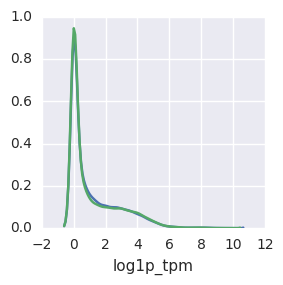

In [28]:
g = sns.FacetGrid(annotated_summary.loc[annotated_summary['CD19']=='+',:], hue='sample_id')
g.map(sns.distplot, 'log1p_tpm', hist=False)

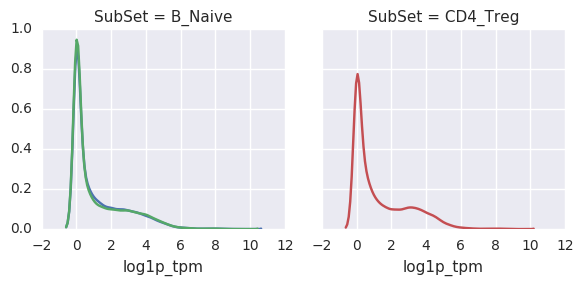

In [29]:
g = sns.FacetGrid(annotated_summary, hue='sample_id', col='SubSet')
g.map(sns.distplot, 'log1p_tpm', hist=False)


## load files by cell type

In [30]:
# list types of cells
subsets['SubSet'].unique()

array(['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1',
       'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory',
       'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17'], dtype=object)

In [31]:
def load_by_cell_type(cell_types, metadata,
                      prep_simple_summary=prep_simple_summary,
                      load_multiple_files=load_multiple):
    file_ids = []
    [file_ids.extend(list(metadata.loc[metadata.SubSet == cell_type, 'filename'].values)) for cell_type in cell_types]
    simple_summary_data = prep_simple_summary(load_multiple_files(file_ids))
    simple_summary_data['log1p_tpm'] = np.log1p(simple_summary_data['tpm'])
    simple_summary_data['log1p_counts'] = np.log1p(simple_summary_data['est_counts'])
    return pd.merge(simple_summary_data, metadata, on='filename', how='left')

In [48]:
annotated_summary = load_by_cell_type(['B_Naive','CD4_Treg','B_CD5'], metadata=subsets)

Copying gs://mz-hammerlab/output/ERR431568.tar.gz...
Copying gs://mz-hammerlab/output/ERR431568.logs.tar.gz...
output/ERR431568/
output/ERR431568/abundance.tsv
output/ERR431568/abundance.h5
output/ERR431568/run_info.json
logs/ERR431568/out.txt
logs/ERR431568/sar.txt
logs/ERR431568/time.txt
downloaded ERR431568 files to ./data
Copying gs://mz-hammerlab/output/ERR431591.tar.gz...
Copying gs://mz-hammerlab/output/ERR431591.logs.tar.gz...
output/ERR431591/
output/ERR431591/abundance.tsv
output/ERR431591/run_info.json
output/ERR431591/abundance.h5
logs/ERR431591/out.txt
logs/ERR431591/sar.txt
logs/ERR431591/time.txt
downloaded ERR431591 files to ./data
Copying gs://mz-hammerlab/output/ERR431596.tar.gz...
Copying gs://mz-hammerlab/output/ERR431596.logs.tar.gz...
output/ERR431596/
output/ERR431596/run_info.json
output/ERR431596/abundance.h5
output/ERR431596/abundance.tsv
logs/ERR431596/out.txt
logs/ERR431596/sar.txt
logs/ERR431596/time.txt
downloaded ERR431596 files to ./data
Copying gs://mz-

In [49]:
annotated_summary.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CD25,CD27,CD4,CD45RA,CD45RO,CD5,CD8,CRTH2,CXCR3,SubSet
0,1,ERR431572,A1BG,80.232280,11.155641,2.497793,4.397313,None,None,None,...,None,-,None,None,None,-,None,None,None,B_Naive
1,1,ERR431572,A1CF,18.042401,0.382263,0.323722,2.946668,None,None,None,...,None,-,None,None,None,-,None,None,None,B_Naive
2,1,ERR431572,A2M,3.000000,1.226161,0.800279,1.386294,None,None,None,...,None,-,None,None,None,-,None,None,None,B_Naive
3,1,ERR431572,A2ML1,21.912401,2.756862,1.323584,3.131678,None,None,None,...,None,-,None,None,None,-,None,None,None,B_Naive
4,1,ERR431572,A2MP1,2.000000,0.092441,0.088415,1.098612,None,None,None,...,None,-,None,None,None,-,None,None,None,B_Naive


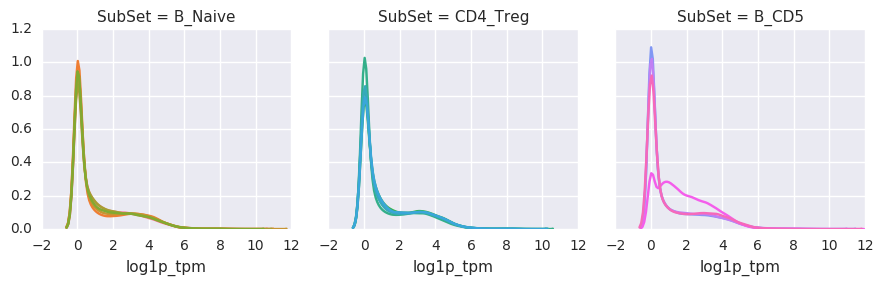

In [50]:
g = sns.FacetGrid(annotated_summary, hue='sample_id', col='SubSet')
g.map(sns.distplot, 'log1p_tpm', hist=False)

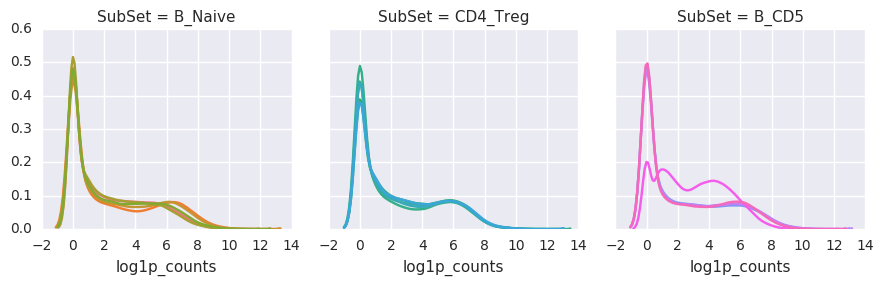

In [51]:
g = sns.FacetGrid(annotated_summary, hue='sample_id', col='SubSet')
g.map(sns.distplot, 'log1p_counts', hist=False)

In [52]:
## summarize mean of log1p_tpm by gene_name & SubSet
summarized = annotated_summary.groupby(['SubSet','gene_name']).agg({'log1p_tpm': np.mean, 'tpm': np.median})
summarized.reset_index(inplace=True)
summarized['rank'] = summarized.groupby('SubSet')["log1p_tpm"].rank()

In [53]:
summarized_wide = summarized.pivot(index='gene_name', columns='SubSet', values='rank')
summarized_wide.reset_index(inplace=True)
summarized = pd.merge(summarized, summarized_wide, on='gene_name')

In [54]:
summarized.head()

,SubSet,gene_name,tpm,log1p_tpm,rank,B_CD5,B_Naive,CD4_Treg
0,B_CD5,A1BG,12.833928,2.741099,28053.0,28053.0,28321.0,27665.0
1,B_Naive,A1BG,11.155641,2.736335,28321.0,28053.0,28321.0,27665.0
2,CD4_Treg,A1BG,15.212151,2.710945,27665.0,28053.0,28321.0,27665.0
3,B_CD5,A1CF,0.168923,0.394499,14047.0,14047.0,16010.0,14327.0
4,B_Naive,A1CF,0.200204,0.248877,16010.0,14047.0,16010.0,14327.0


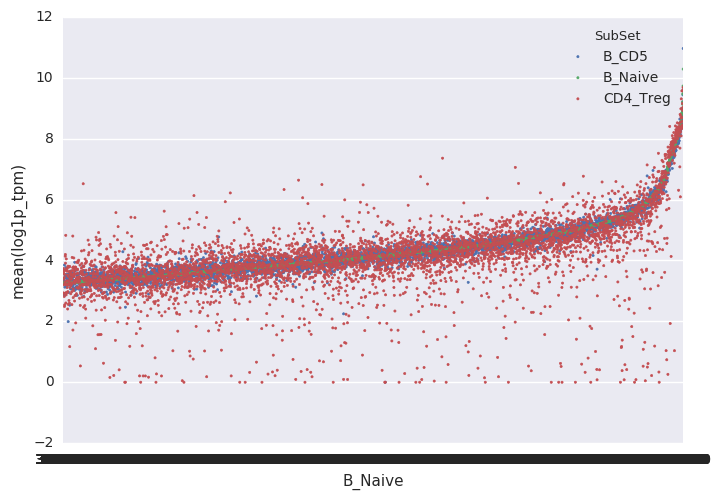

In [56]:
sns.pointplot(data=summarized.loc[summarized['B_Naive']>=30000,:],
              x='B_Naive', y='log1p_tpm', hue='SubSet', join=False, scale=0.2, ci=None, alpha=0.2)

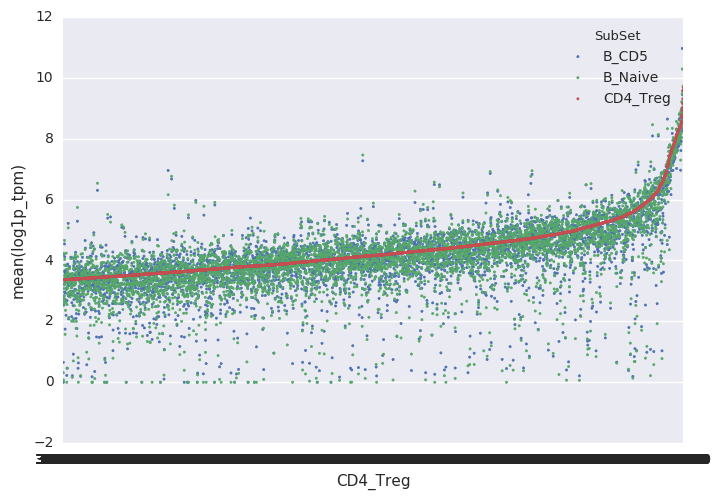

In [57]:
sns.pointplot(data=summarized.loc[summarized['CD4_Treg']>=30000,:],
              x='CD4_Treg', y='log1p_tpm', hue='SubSet',
              join=False, scale=0.2, ci=None, alpha=0.2)

In [58]:
#sns.pointplot(data=summarized.loc[summarized['CD4_Treg']<30000,:],
#              x='CD4_Treg', y='log1p_tpm', hue='SubSet', join=False, scale=0.2, ci=None)

In [59]:
summarized_wide2 = summarized.pivot(index='gene_name', columns='SubSet', values='log1p_tpm')
summarized_wide2.reset_index(inplace=True)

In [73]:
summarized_wide2['diff_Treg'] = summarized_wide2.apply(lambda row: row['B_Naive'] - row['CD4_Treg'], axis=1)
summarized_wide2['diff_B_CD5'] = summarized_wide2.apply(lambda row: row['B_Naive'] - row['B_CD5'], axis=1)
summarized_wide2['average'] = summarized_wide2.apply(lambda row: (row['B_Naive'] + row['CD4_Treg'] + row['B_CD5'])/3, axis=1)
summarized_wide2['reldiff_Treg'] = summarized_wide2.apply(lambda row: row['diff_Treg']/(0.001+row['average']), axis=1)
summarized_wide2['reldiff_B_CD5'] = summarized_wide2.apply(lambda row: row['diff_B_CD5']/(0.001+row['average']), axis=1)

In [74]:
summarized_wide2.head()

SubSet,gene_name,B_CD5,B_Naive,CD4_Treg,diff,average,rel_diff,diff_Treg,diff_B_CD5,reldiff_Treg,reldiff_B_CD5
0,A1BG,2.741099,2.736335,2.710945,0.025390,2.729460,0.009299,0.025390,-0.004764,0.009299,-0.001745
1,A1CF,0.394499,0.248877,0.216077,0.032800,0.286484,0.114094,0.032800,-0.145622,0.114094,-0.506538
2,A2M,0.721151,0.388976,0.719375,-0.330399,0.609834,-0.540898,-0.330399,-0.332175,-0.540898,-0.543806
3,A2ML1,1.203950,0.911689,0.905455,0.006233,1.007031,0.006184,0.006233,-0.292261,0.006184,-0.289933
4,A2MP1,0.192955,0.131818,0.432902,-0.301084,0.252558,-1.187436,-0.301084,-0.061137,-1.187436,-0.241115


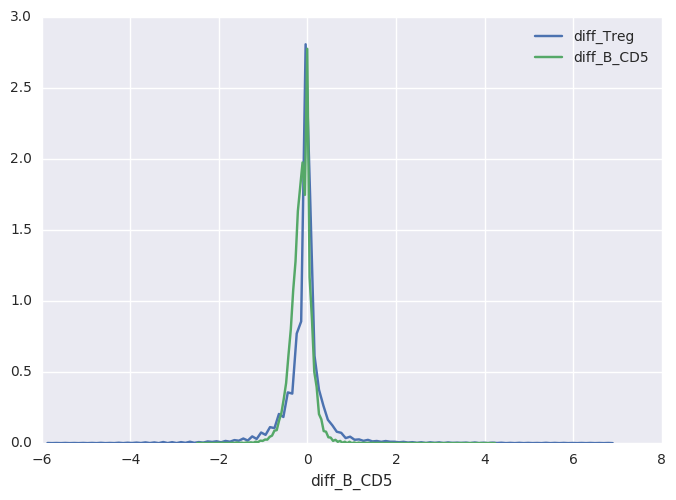

In [75]:
sns.distplot(summarized_wide2['diff_Treg'], hist=False, label='diff_Treg')
sns.distplot(summarized_wide2['diff_B_CD5'], hist=False, label='diff_B_CD5')
plt.legend()

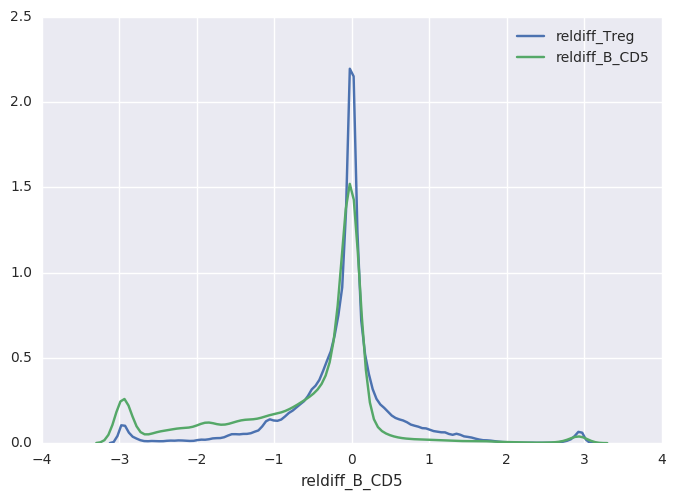

In [76]:
sns.distplot(summarized_wide2['reldiff_Treg'], hist=False, label='reldiff_Treg')
sns.distplot(summarized_wide2['reldiff_B_CD5'], hist=False, label='reldiff_B_CD5')
plt.legend()

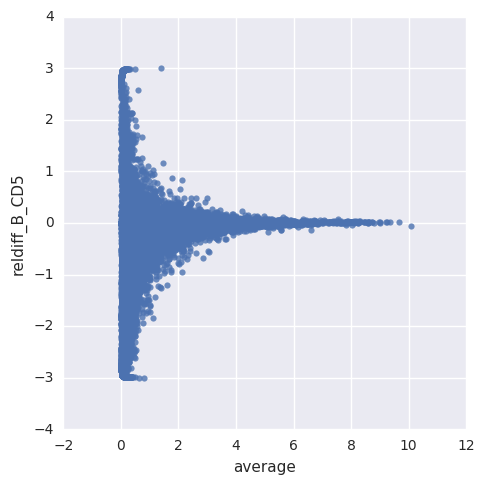

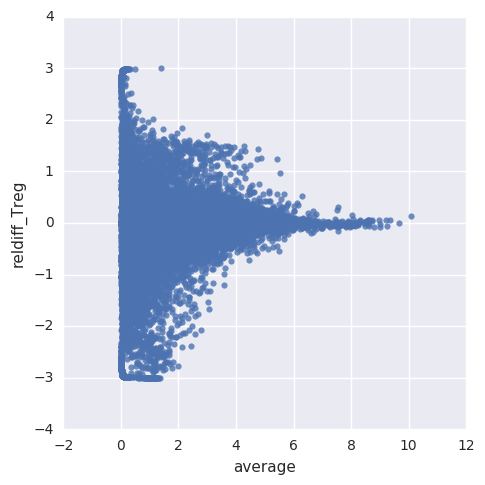

In [79]:
sns.lmplot(data=summarized_wide2, x='average', y='reldiff_B_CD5', fit_reg=False, ci=None)
sns.lmplot(data=summarized_wide2, x='average', y='reldiff_Treg', fit_reg=False, ci=None)
